### Assignment Booking.com Feature Extraction

In [57]:
# importing libraries

import os
import pickle
import pandas as pd
import spacy
import nltk
import sys
from tqdm import tqdm
import time
import ipyparallel
from collections import Counter

In [14]:
# loading spacy model

sp = spacy.load("en_core_web_sm")
sp.max_length = 20000000
sp.pipe_names
#en_core_web_lg is 79 time larger than en_core_web_sm

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [12]:
# checking current directory

os.getcwd()

'C:\\Users\\amits\\OneDrive - University of South Florida\\Fall 2022 Classes\\Text Analytics'

File was read above directory and pickled for faster retrieval

In [393]:
# data = pd.read_excel(r'C:\Users\amits\OneDrive - University of South Florida\Fall 2022 Classes\Text Analytics\week 4 tf idf\BookingDotCom_HotelReviews.xlsx'
#                     ,sheet_name='Data')

# removing unnecessary fields to reduce data size
# data.drop(columns=['Reviewer_Nationality'], inplace=True)

In [394]:
# saving data as binary file
# with open('booking_pickle','wb') as pkl_file:
#     pickle.dump(data,pkl_file)

In [15]:
# reading pickled file
with open('booking_pickle','rb') as pkl_file:
    data = pickle.load(pkl_file)

In [16]:
# inspecting data
data.head(2)

,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Positive_Comments,Negative_Comments,Total_Reviewer_Reviews,Reviewer_Score,Tags
0,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double..."
1,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,No real complaints the hotel was great great ...,No Negative,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double..."


Running Spacy Model on Positive_Comments And Negative_Comments field to extract Noun Phrases

In [33]:
# resource intentive process

sp = spacy.load("en_core_web_sm")

# disableing unneccessary pipes to speed up the process
sp.disable_pipes(['lemmatizer','ner'])
# tok2vec,attribute_ruler,tagger is used in noun chunks, do not disable it

# empty lists for storing results
pos = list()
pos_np = list()
pos_doc = list()
for i in tqdm(range(len(data))):
        pos_np = list()
        doc = sp(str(data['Positive_Comments'][i]))
        ind_val = data.index.values[i]
        pos_doc.append(doc)
        for np in doc.noun_chunks:
            pos_np.append(np)
        pos.append((ind_val,(pos_np)))

100%|█████████████████████████████████████████████████████████████████████████| 515738/515738 [20:55<00:00, 410.74it/s]


In [37]:
# resource intentive process
sp = spacy.load("en_core_web_sm")

# disableing unneccessary pipes to speed up the process
sp.disable_pipes(['lemmatizer','ner'])
# tok2vec,attribute_ruler,tagger  is used in noun chunks, do not disable it

# empty lists for storing results
neg = list()
neg_np = list()
neg_doc = list()
for i in tqdm(range(len(data))):
        neg_np = list()
        doc = sp(str(data['Negative_Comments'][i]))
        ind_val = data.index.values[i]
        neg_doc.append(doc)
        for np in doc.noun_chunks:
            neg_np.append(np)
        neg.append((ind_val,(neg_np)))

100%|█████████████████████████████████████████████████████████████████████████| 515738/515738 [23:14<00:00, 369.82it/s]


In [40]:
# saving spacy doc as binary file
# with open('neg_doc','wb') as pkl_file:
#     pickle.dump(neg_doc,pkl_file)

In [41]:
print(type(pos))
print(len(pos))
print(sys.getsizeof(pos))

<class 'list'>
515738
4167352


In [42]:
print(type(neg))
print(len(neg))
print(sys.getsizeof(neg))

<class 'list'>
515738
4167352


In [43]:
# saving lists as dataframes

df_pos_phrase = pd.DataFrame(pos,columns=['id','pos_noun_phrases'])
df_pos_phrase.set_index('id',inplace=True)
df_pos_phrase.head(2)

# df_pos_phrase.to_csv('df_pos_phrase.csv')

,pos_noun_phrases
id,
0,"[( , Only, the, park), (the, hotel)]"
1,"[(the, hotel), (great, great, location, surrou..."


In [44]:
df_neg_phrase = pd.DataFrame(neg,columns=['id','neg_noun_phrases'])
df_neg_phrase.set_index('id',inplace=True)
df_neg_phrase.head(2)

# df_neg_phrase.to_csv('df_neg_phrase.csv')

,neg_noun_phrases
id,
0,"[(I), (i), (this, post), (all, possible, sites..."
1,"[(No, Negative)]"


In [45]:
# joining the positive and negative noun phrases to original dataset on id field

data_pos = df_pos_phrase.join(data)
data_pos = df_neg_phrase.join(data_pos)

print(data_pos.shape)
data_pos.head(2)

(515738, 13)


,neg_noun_phrases,pos_noun_phrases,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Positive_Comments,Negative_Comments,Total_Reviewer_Reviews,Reviewer_Score,Tags
id,,,,,,,,,,,,,
0,"[(I), (i), (this, post), (all, possible, sites...","[( , Only, the, park), (the, hotel)]",Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double..."
1,"[(No, Negative)]","[(the, hotel), (great, great, location, surrou...",Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,No real complaints the hotel was great great ...,No Negative,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double..."


In [46]:
# adding flag to each each row based on Tags field
import ast

rowid = list()
solo_traveler = list()
couple = list()
group = list()
leisure_trip = list()
business_trip = list()
family = list()

def tags_ext(m):
    for i in tqdm(range(m)):
        
        # extracting index for the row, fes rows might be empty hence can not use system generated index
        ind_val = data.index.values[i]
        
        # cleaning Tag field, removing string quotes and storing it as a list in a variable
        tag_clean = ast.literal_eval(data['Tags'][i])
        
        # removing leading and trailing spaces and assigning flags
        st = (1 if 'solo traveler' in [str(k).strip().lower() for k in tag_clean] else 0)
        cp = (1 if 'couple' in [str(k).lower().strip() for k in tag_clean] else 0)
        gp = (1 if 'group' in [str(k).lower().strip() for k in tag_clean] else 0)
        lt = (1 if 'leisure trip' in [str(k).lower().strip() for k in tag_clean] else 0)
        bt = (1 if 'business trip' in [str(k).lower().strip() for k in tag_clean] else 0)
        fm = (1 if 'family with young children' in [str(k).lower().strip() for k in tag_clean] else 0)
        
        # appending to list in order
        rowid.append(ind_val)
        solo_traveler.append(st) 
        couple.append(cp)
        group.append(gp)
        leisure_trip.append(lt)
        business_trip.append(bt)
        family.append(fm)

In [47]:
# running the above function on whole dataset
tags_ext(len(data))

100%|███████████████████████████████████████████████████████████████████████| 515738/515738 [00:09<00:00, 51753.21it/s]


In [48]:
print(len(data))
print(len(rowid))

515738
515738


In [49]:
# saving lists as dataframe

df_tags = pd.DataFrame(rowid,columns=['rowid'])
df_tags.set_index('rowid',inplace= True)

df_tags['solo_traveler'] = solo_traveler
df_tags['couple'] = couple
df_tags['group'] = group
df_tags['leisure_trip'] = leisure_trip
df_tags['business_trip'] = business_trip
df_tags['family'] = family

print(df_tags.shape)
df_tags.head(2)

# joining tags to original dataset
data_pos = data_pos.join(df_tags)

(515738, 6)


In [50]:
# dropping Processed fields
data_pos.drop(columns=['Tags','Positive_Comments','Negative_Comments'], inplace=True)

In [51]:
print(data_pos.shape)
data_pos.head(2)

(515738, 16)


,neg_noun_phrases,pos_noun_phrases,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Total_Reviewer_Reviews,Reviewer_Score,solo_traveler,couple,group,leisure_trip,business_trip,family
id,,,,,,,,,,,,,,,,
0,"[(I), (i), (this, post), (all, possible, sites...","[( , Only, the, park), (the, hotel)]",Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,7,2.9,0,1,0,1,0,0
1,"[(No, Negative)]","[(the, hotel), (great, great, location, surrou...",Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,7,7.5,0,1,0,1,0,0


In [52]:
# saving final dataset to csv (read list as list and not as strings)
# data_pos.to_csv('booking.csv')

# data_pos = pd.read_csv('booking.csv')

# cant save or pickle span, need to explore on saving mechanism
type(data_pos['pos_noun_phrases'][0][0])

spacy.tokens.span.Span

#### <font color = 'blue'> Question 1 Answer </font>

In [65]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
spacy_stopwords.add('no negative')
spacy_stopwords.add('didn t')
spacy_stopwords.add('t')
def feature_extraction(field_name):
    
    overall_phrases = list()
    
    # saving text from noun phrases to list (span type)
    for k in tqdm(range(len(data_pos))):
        temp = [i.text.strip().lower() for i in data_pos[field_name][k] ]
        overall_phrases.extend(temp)

    # removing stop words from list

    tp = [i for i in overall_phrases if i not in spacy_stopwords ]
    phrase_counts = Counter(tp)

    if field_name=='pos_noun_phrases':
        print('The Top 5 hotel features that customers mention the most in positive reviews')
    else:
        print('The Top 5 hotel features that customers mention the most in negative reviews')
    return phrase_counts.most_common(5)

The Top 5 hotel features that customers mention the most in positive reviews

In [60]:
feature_extraction('pos_noun_phrases')

100%|███████████████████████████████████████████████████████████████████████| 515738/515738 [00:05<00:00, 94059.21it/s]


The Top 5 hotel features that customers mention the most in positive reviews


[('the staff', 45068),
 ('the hotel', 42036),
 ('location', 40809),
 ('the room', 37192),
 ('the location', 31154)]

The Top 5 hotel features that customers mention the most in negative reviews

In [66]:
feature_extraction('neg_noun_phrases')

100%|███████████████████████████████████████████████████████████████████████| 515738/515738 [00:05<00:00, 91917.17it/s]


The Top 5 hotel features that customers mention the most in negative reviews


[('the room', 52573),
 ('the hotel', 29395),
 ('room', 23494),
 ('breakfast', 23487),
 ('rooms', 10028)]

#### <font color = 'blue'>Question 2 </font>

In [430]:
print(len(data_pos))
print(len(df_solo))

# qc
sum(data_pos['solo_traveler'])

515738
108545


In [92]:
def tag_features(traveler_type): 
    
    df = data_pos[data_pos[traveler_type]==1]
    ind = df.index
    positive_phrases = list()
    
    for k in tqdm(ind):
        temp = [i.text.strip().lower() for i in df['pos_noun_phrases'][k] ]
        positive_phrases.extend(temp)

    pos_five = [i for i in positive_phrases if i not in spacy_stopwords ]
    pos_phrase_counts = Counter(pos_five)

    print('The Top 5 Hotel Features For', ' '.join(traveler_type.title().split('_')))
    return pos_phrase_counts.most_common(5)

The Top 5 Hotel Features For Solo Travelers

In [93]:
# select from solo_traveler, couple, group, leisure_trip, business_trip, family
tag_features('solo_traveler')

100%|███████████████████████████████████████████████████████████████████████| 108545/108545 [00:01<00:00, 92984.03it/s]


The Top 5 Hotel Features For Solo Traveler


[('location', 8956),
 ('the staff', 7779),
 ('the room', 7372),
 ('the hotel', 6695),
 ('the location', 5866)]

The Top 5 Hotel Features For Couples

In [94]:
tag_features('couple')

100%|███████████████████████████████████████████████████████████████████████| 252294/252294 [00:02<00:00, 87861.97it/s]


The Top 5 Hotel Features For Couple


[('the staff', 23415),
 ('the hotel', 22218),
 ('the room', 20133),
 ('location', 18852),
 ('staff', 15741)]

The Top 5 Hotel Features For Group Travellers

In [95]:
tag_features('group')

100%|█████████████████████████████████████████████████████████████████████████| 65392/65392 [00:00<00:00, 85881.56it/s]

The Top 5 Hotel Features For Group


[('the staff', 5930),
 ('the hotel', 5608),
 ('location', 4952),
 ('the room', 4189),
 ('the location', 4111)]

The Top 5 Hotel Features For Leisure Trips

In [96]:
tag_features('leisure_trip')

100%|███████████████████████████████████████████████████████████████████████| 417778/417778 [00:04<00:00, 91948.64it/s]


The Top 5 Hotel Features For Leisure Trip


[('the staff', 39036),
 ('the hotel', 36703),
 ('location', 32604),
 ('the room', 31507),
 ('the location', 26641)]

The Top 5 Hotel Features For Business Trips

In [97]:
tag_features('business_trip')

100%|████████████████████████████████████████████████████████████████████████| 82939/82939 [00:00<00:00, 101618.01it/s]

The Top 5 Hotel Features For Business Trip


[('location', 7132),
 ('the staff', 4737),
 ('the room', 4630),
 ('the hotel', 4301),
 ('staff', 4049)]

The Top 5 Hotel Features For Family Trips

In [98]:
tag_features('family')

100%|█████████████████████████████████████████████████████████████████████████| 61015/61015 [00:00<00:00, 87562.66it/s]

The Top 5 Hotel Features For Family


[('location', 5422),
 ('the staff', 5357),
 ('the hotel', 5176),
 ('the location', 4106),
 ('the room', 3833)]

#### <font color = 'blue'>Question 3</font>

In [100]:
# Named Entity Extraction

sp = spacy.load("en_core_web_sm", disable=['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])

country = list()
doc_ner_list = list()

for i in tqdm(range(len(data_pos))):
    ind_val = data_pos.index.values[i]
    doc = sp(data_pos['Hotel_Address'][i])
    doc_ner_list.append(doc)
    for ent in doc.ents:
        if ent.label_ == 'GPE':
            country.append((ind_val,ent.text))

100%|█████████████████████████████████████████████████████████████████████████| 515738/515738 [15:58<00:00, 538.29it/s]


In [ ]:
# saving spacy doc as binary file
doc_data = pickle.dumps([doc_ner_list, pos_doc, neg_doc])

In [101]:
# few rows have multiple GPE
print(len(country))

809759


In [102]:
df_country = pd.DataFrame(country, columns = ['id','country'])

In [103]:
uk = list()
fr = list()
it = list()
sp = list()

# extracting rows indexes from above dataframe for each country 
for i in tqdm(range(len(df_country))):
    ind_val = df_country.index.values[i]
    if 'United Kingdom' in (df_country['country'][i]):
        uk.append((df_country['id'][i],1))
    if 'France' in (df_country['country'][i]):
        fr.append((df_country['id'][i],1))
    if 'Italy' in (df_country['country'][i]):
        it.append((df_country['id'][i],1))
    if 'Spain' in (df_country['country'][i]):
        sp.append((df_country['id'][i],1))

# savinf lists as dataframe with indexes
df_uk = pd.DataFrame(uk,columns=['id','uk_yes'])
df_uk.set_index('id',inplace=True)

df_fr = pd.DataFrame(fr,columns=['id','fr_yes'])
df_fr.set_index('id',inplace=True)

df_it = pd.DataFrame(it,columns=['id','it_yes'])
df_it.set_index('id',inplace=True)

df_sp = pd.DataFrame(sp,columns=['id','sp_yes'])
df_sp.set_index('id',inplace=True)

# joining flags info with original dataset
data_flags = data_pos.join(df_uk)
data_flags = data_flags.join(df_fr)
data_flags = data_flags.join(df_it)
data_flags = data_flags.join(df_sp)

100%|███████████████████████████████████████████████████████████████████████| 809759/809759 [00:10<00:00, 75258.52it/s]


In [106]:
data_flags.head(2)

,neg_noun_phrases,pos_noun_phrases,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Total_Reviewer_Reviews,Reviewer_Score,solo_traveler,couple,group,leisure_trip,business_trip,family,uk_yes,fr_yes,it_yes,sp_yes
id,,,,,,,,,,,,,,,,,,,,
0,"[(I), (i), (this, post), (all, possible, sites...","[( , Only, the, park), (the, hotel)]",Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,7,2.9,0,1,0,1,0,0,NaN,NaN,NaN,NaN
1,"[(No, Negative)]","[(the, hotel), (great, great, location, surrou...",Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,7,7.5,0,1,0,1,0,0,NaN,NaN,NaN,NaN


In [110]:
# function for extracting top 5 negative complaints from the review
def negative_complaints(country):
    negative_phrases = list()
    ind = data_flags[data_flags[country]==1].index
    
    for k in tqdm(ind):
        temp = [i.text.strip().lower() for i in data_flags['neg_noun_phrases'][k] ]
        negative_phrases.extend(temp)

    neg_five = [i for i in negative_phrases if i not in spacy_stopwords ]
    neg_phrase_counts = Counter(neg_five)
    print('The Top 5 Complaints For Hotels In The', country[0:2].upper())
    return neg_phrase_counts.most_common(5)

# function for extracting top 5 positive features from the review
def positive_features(country):
    positive_phrases = list()
    ind = data_flags[data_flags[country]==1].index
    
    for k in tqdm(ind):
        temp = [i.text.strip().lower() for i in data_flags['pos_noun_phrases'][k] ]
        positive_phrases.extend(temp)

    pos_five = [i for i in positive_phrases if i not in spacy_stopwords ]
    pos_phrase_counts = Counter(pos_five)
    print('The Top 5 Preffered Hotel Features For Hotels In The', country[0:2].upper())
    return pos_phrase_counts.most_common(5)

The Top 5 Preffered Hotel Features For Hotels In The UK

In [111]:
positive_features('uk_yes')

100%|███████████████████████████████████████████████████████████████████████| 258865/258865 [00:02<00:00, 95433.20it/s]


The Top 5 Preffered Hotel Features For Hotels In The UK


[('the staff', 21459),
 ('location', 20937),
 ('the room', 18327),
 ('the hotel', 16932),
 ('staff', 16476)]

The Top 5 Complaints For Hotels In The United Kingdon

In [112]:
negative_complaints('uk_yes')

100%|███████████████████████████████████████████████████████████████████████| 258865/258865 [00:08<00:00, 30280.46it/s]


The Top 5 Complaints For Hotels In The UK


[('the room', 27806),
 ('room', 14197),
 ('the hotel', 12718),
 ('breakfast', 12553),
 ('the bed', 5752)]

The Top 5 Preffered Hotel Features For Hotesl In The France

In [113]:
positive_features('fr_yes')

100%|███████████████████████████████████████████████████████████████████████████| 1506/1506 [00:00<00:00, 24769.80it/s]

The Top 5 Preffered Hotel Features For Hotels In The FR


[('the staff', 194),
 ('the hotel', 169),
 ('the location', 141),
 ('paris', 137),
 ('the room', 131)]

The Top 5 Complaints For Hotels In The France

In [114]:
negative_complaints('fr_yes')

100%|███████████████████████████████████████████████████████████████████████████| 1506/1506 [00:00<00:00, 18092.93it/s]

The Top 5 Complaints For Hotels In The FR


[('the room', 111),
 ('breakfast', 73),
 ('room', 66),
 ('the hotel', 57),
 ('paris', 44)]

The Top 5 Preffered Hotel Features For Hotesl In The Italy

In [115]:
positive_features('it_yes')

100%|█████████████████████████████████████████████████████████████████████████| 37207/37207 [00:00<00:00, 66576.28it/s]


The Top 5 Preffered Hotel Features For Hotels In The IT


[('the hotel', 3402),
 ('the staff', 2837),
 ('location', 2824),
 ('the room', 2589),
 ('breakfast', 2164)]

The Top 5 Complaints For Hotels In The Italy

In [116]:
negative_complaints('it_yes')

100%|█████████████████████████████████████████████████████████████████████████| 37207/37207 [00:00<00:00, 57469.80it/s]

The Top 5 Complaints For Hotels In The IT


[('the room', 3289),
 ('the hotel', 2650),
 ('breakfast', 1830),
 ('room', 1092),
 ('the staff', 778)]

The Top 5 Preffered Hotel Features For Hotesl In The Spain

In [119]:
positive_features('sp_yes')

100%|█████████████████████████████████████████████████████████████████████████| 60149/60149 [00:01<00:00, 53884.13it/s]

The Top 5 Preffered Hotel Features For Hotels In The SP


[('the staff', 5964),
 ('the hotel', 5914),
 ('location', 4850),
 ('the location', 4092),
 ('the room', 3991)]

The Top 5 Complaints For Hotels In The Spain

In [117]:
# pick country from country = 'it_yes','sp_yes','fr_yes','uk_yes'
negative_complaints('sp_yes')

100%|█████████████████████████████████████████████████████████████████████████| 60149/60149 [00:01<00:00, 54358.58it/s]


The Top 5 Complaints For Hotels In The SP


[('the room', 5733),
 ('the hotel', 3795),
 ('breakfast', 2310),
 ('room', 2161),
 ('our room', 1141)]

#### <font color='blue'> Question 4 </font>

In [120]:
# total hotels
len(set(data_flags['Hotel_Name']))

1492

In [126]:
# extracting year field from date field

yr_list = list()
for i in range(len(data_flags)):
    ind_val = data_pos.index.values[i]
    yr_list.append((ind_val,data_flags['Review_Date'][i].year))

In [127]:
# list to dataframe

df_yr_list = pd.DataFrame(yr_list,columns=['id','yr'])
df_yr_list.set_index('id',inplace=True)
df_yr_list.head(2)

,yr
id,
0,2017
1,2017


In [128]:
data_flags.columns

Index(['neg_noun_phrases', 'pos_noun_phrases', 'Hotel_Name', 'Hotel_Address',
       'Review_Count', 'Non_Review_Scoring_Count', 'Average_Hotel_Score',
       'Review_Date', 'Total_Reviewer_Reviews', 'Reviewer_Score',
       'solo_traveler', 'couple', 'group', 'leisure_trip', 'business_trip',
       'family', 'uk_yes', 'fr_yes', 'it_yes', 'sp_yes'],
      dtype='object')

In [131]:
# joining ye with original data
data_flags = data_flags.join(df_yr_list)

# subsetting data for the analysis

data_avg_ratings = data_flags[['Hotel_Name','yr','Reviewer_Score']]
data_avg_ratings.head(3)

,Hotel_Name,yr,Reviewer_Score
id,,,
0,Hotel Arena,2017,2.9
1,Hotel Arena,2017,7.5
2,Hotel Arena,2017,7.1


In [132]:
# avg rating for each year

avg_hotel_ratings = data_avg_ratings.groupby(['Hotel_Name','yr'])['Reviewer_Score'].agg({'mean'})
avg_hotel_ratings.reset_index(inplace=True)
avg_hotel_ratings.head(6)

,Hotel_Name,yr,mean
0,41,2015,9.743333
1,41,2016,9.652083
2,41,2017,9.788000
3,11 Cadogan Gardens,2015,8.016000
4,11 Cadogan Gardens,2016,8.954321
5,11 Cadogan Gardens,2017,9.069811


In [133]:
# calculating mean avg rating using user ratings between 2015-17 to find top 5 and bottom 5 hotels

avg = avg_hotel_ratings.groupby(['Hotel_Name'])['mean'].agg({'mean'})
avg_final = avg_hotel_ratings.merge(avg,on='Hotel_Name')
avg_final.sort_values('mean_y',inplace=True,ascending=False)

In [134]:
# Taking first 5 hotels and bottom 5 hotels for 3 years from sorted dataframe

top5 = avg_final.head(15)
bottom5 = avg_final.tail(15)
top5.reset_index(inplace=True)

In [135]:
# Moving Column Fields To Rows To Calculate Jump In Ratings From 2015 to 2017
pivot = pd.pivot_table(avg_final,values='mean_x',index=['Hotel_Name'],columns = ['yr'])
pivot.reset_index(inplace=True)

pivot['diff'] = pivot[2015]-pivot[2017]
pivot.sort_values(by='diff',ascending=True,inplace=True)

# Keeping Hotels with highest jump in rating
pivot.head(5)

yr,Hotel_Name,2015,2016,2017,diff
883,Le Lavoisier,2.500000,8.150000,10.000000,-7.500000
987,Mercure Paris Bastille Saint Antoine,5.000000,7.478571,7.566667,-2.566667
853,L Edmond H tel,6.450000,8.171429,8.572727,-2.122727
1012,MiHotel,7.125000,8.810000,9.075000,-1.950000
1456,Villa Lut ce Port Royal,5.594444,6.741667,7.520000,-1.925556


(1) "Top Five Hotels Overall" with consistently high ratings

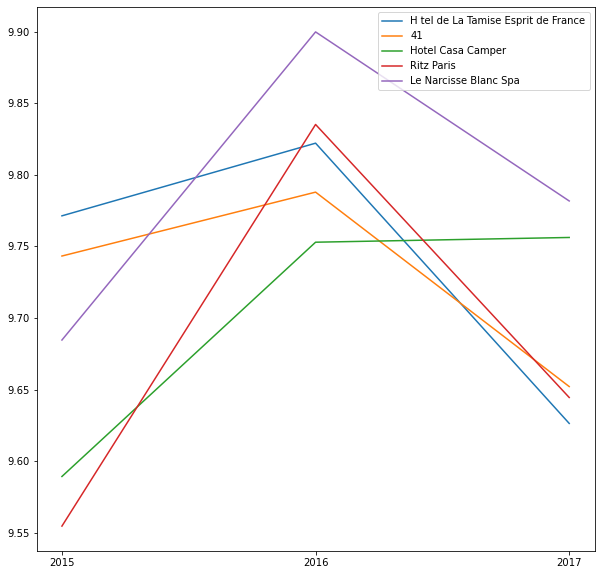

In [824]:
import matplotlib.pyplot as plt

yr = ['2015','2016','2017']
plt.figure(figsize=(10,10))
for i in range(0,15,3):
    plt.plot(yr,top5['mean_x'].iloc[i:i+3],label=top5['Hotel_Name'][i])
plt.legend(loc='upper right')

(2) Bottom Five Hotels Overall" with consistently low ratings

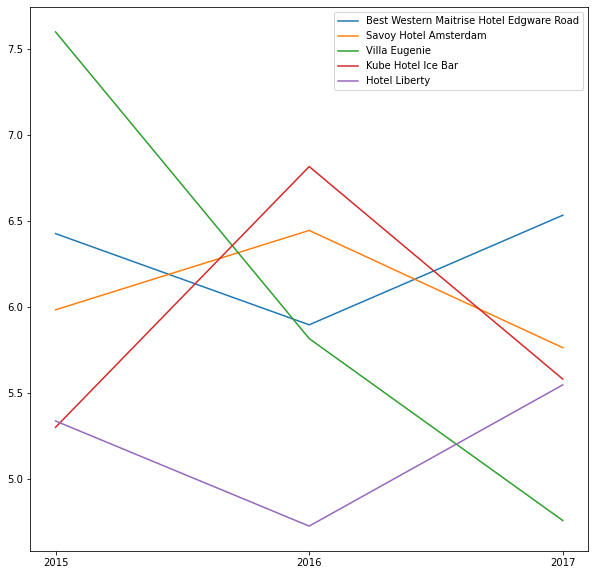

In [825]:
bottom5.index = range(15)
yr = ['2015','2016','2017']
plt.figure(figsize=(10,10))

for i in range(0,15,3):
    plt.plot(yr,bottom5['mean_x'].iloc[i:i+3],label=bottom5['Hotel_Name'][i])

plt.legend(loc='upper right')

(3) Five Most Improved Hotels" (2015 to 2017)

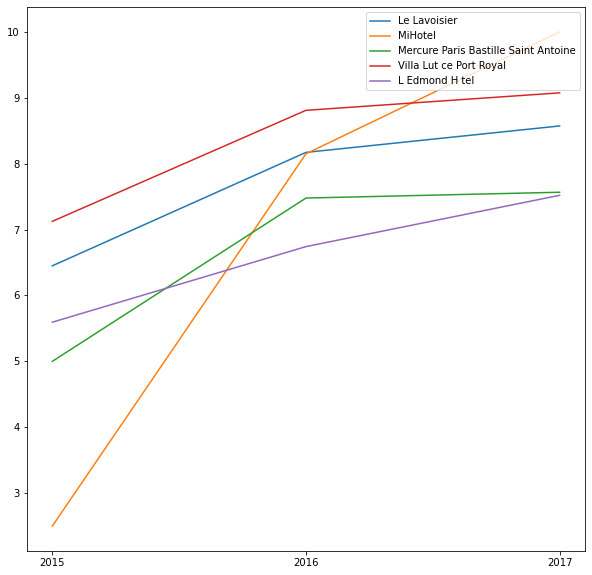

In [848]:
unpivot = pd.melt(pivot.iloc[0:5], id_vars=['Hotel_Name'], value_vars=[2015,2016,2017])
unpivot.sort_values(by=['Hotel_Name','yr'],inplace=True)
unpivot
yr = ['2015','2016','2017']
plt.figure(figsize=(10,10))

for i in range(0,15,3):
    plt.plot(yr,unpivot['value'].iloc[i:i+3],label=unpivot['Hotel_Name'][i])
plt.legend(loc='upper right')

#### Tried Using Quintiles To Find Consistent Hotels

In [649]:
quantiles = data_flags.groupby('Hotel_Name')['Reviewer_Score'].apply(lambda x: x.quantile([0.25,0.5,0.75]) )

In [660]:
df_quantiles = pd.DataFrame(quantiles)
df_quantiles.head(10)                         

Reviewer_Score
Hotel_Name                                             
41                                 0.25             9.6
                                   0.50            10.0
                                   0.75            10.0
11 Cadogan Gardens                 0.25             8.3
                                   0.50             9.2
                                   0.75            10.0
1K Hotel                           0.25             7.1
                                   0.50             8.1
                                   0.75             9.2
25hours Hotel beim MuseumsQuartier 0.25             8.3

In [668]:
df_quantiles.reset_index(inplace=True)

In [671]:
df_quantiles.head(4)

,Hotel_Name,level_1,Reviewer_Score
0,41,0.25,9.6
1,41,0.50,10.0
2,41,0.75,10.0
3,11 Cadogan Gardens,0.25,8.3


In [684]:
top_hotels_by_ratings = df_quantiles[(df_quantiles['level_1']==0.25) & (df_quantiles['Reviewer_Score']>=9)]
top_hotels_by_ratings.sort_values(by='Reviewer_Score',ascending=False,inplace=True)
print('Top Five Hotels with consistently high ratings')
top_hotesl_by_ratings.head(5)

Top Five Hotels with consistently high ratings


C:\Users\amits\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Hotel_Name,level_1,Reviewer_Score
0,41,0.25,9.6
2196,Hotel Plaza Athenee Paris,0.25,9.6
1002,Four Seasons Hotel George V Paris,0.25,9.6
1272,H tel Fabric,0.25,9.6
1416,H tel de La Tamise Esprit de France,0.25,9.6


In [692]:
bottom_hotels_by_ratings = df_quantiles[(df_quantiles['level_1']==0.75) & (df_quantiles['Reviewer_Score']<=8)]
bottom_hotels_by_ratings.sort_values(by='Reviewer_Score',ascending=False,inplace=True)
print('Bottom Five Hotels with consistently low ratings')
bottom_hotels_by_ratings.head(5)

Bottom Five Hotels with consistently low ratings


C:\Users\amits\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Hotel_Name,level_1,Reviewer_Score
425,Best Western Maitrise Hotel Edgware Road,0.75,7.9
1481,Hallmark Hotel London Chigwell Prince Regent,0.75,7.9
2951,Mercure Paris 19 Philharmonie La Villette,0.75,7.9
2468,Idea Hotel Milano San Siro,0.75,7.9
533,Bloomsbury Palace Hotel,0.75,7.9


The End